# Imports and Definitions

In [1]:
import sys
sys.path.append('../')

In [2]:
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=1.2)
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from utils.data_utils import preprocess_and_normalize_energy_data, parse_codecarbon_output
from sklearn.linear_model import LinearRegression, Lasso
from utils.experiments_utils import split_data_set, fit_model, compute_log_transformed_features, apply_data_transforms, test_model
from sklearn.metrics import r2_score
%load_ext autoreload
%autoreload 2
SEED = 1234

In [3]:
models = {}
estimates = {}

# Conv2d Module
## Load Data

In [4]:
d1 = parse_codecarbon_output(
    '../data/conv2d/00_conv2d-raw.csv',
    False,
    ('../data/conv2d/00_conv2d-slurm-log.out','conv2d',False,3)
)
print("dataset shape:", d1.shape)

Dropped observations with the following indices: [24, 69, 102, 175, 183, 303, 382, 406, 467, 552, 619, 751, 761, 853, 901, 902, 955, 1009, 1041, 1060, 1089, 1106, 1225, 1230, 1330, 1365, 1423, 1449]
dataset shape: (1472, 32)


In [5]:
d2 = parse_codecarbon_output(
    '../data/conv2d/02_conv2d-raw.csv',
    False,
    ('../data/conv2d/02_conv2d-slurm-log.out','conv2d',True,3)
)
print("dataset shape:", d2.shape)

Dropped observations with the following indices: [6, 7, 8, 21, 22, 23, 60, 61, 62, 165, 166, 167, 174, 175, 176, 228, 229, 230, 246, 247, 248, 303, 304, 305, 456, 457, 458, 498, 499, 500, 546, 547, 548, 666, 667, 668, 675, 676, 677, 783, 784, 785, 798, 799, 800, 864, 865, 866, 897, 898, 899, 945, 946, 947, 1107, 1108, 1109, 1113, 1114, 1115, 1242, 1243, 1244, 1362, 1363, 1364, 1371, 1372, 1373, 1452, 1453, 1454]
dataset shape: (1428, 32)


In [6]:
d2

timestamp                                run_id   duration  \
0     2022-12-14T11:19:51  008b8322-d5b6-4cf7-8a0b-9c2a700dccf4  30.119765   
1     2022-12-14T11:20:26  f3ace698-f36c-4f83-ab6e-dfcfe4e06a69  30.099975   
2     2022-12-14T11:21:00  50206b21-fcdc-457f-a724-e6d4feee6c0e  30.091210   
3     2022-12-14T11:21:35  0b6391a3-54ab-4813-99d5-63acabc11424  30.400764   
4     2022-12-14T11:22:10  b41d9f92-28c6-4259-b137-33d1510760af  30.437471   
...                   ...                                   ...        ...   
1495  2022-12-15T18:01:44  4f45bba5-50da-4b7b-9a00-28735bb41216  33.733295   
1496  2022-12-15T18:02:27  d6f120d8-45e1-4708-b0b6-a68dea43025f  33.681908   
1497  2022-12-15T18:03:37  b032af29-3688-44c2-9244-79af6bdaeefd  57.059258   
1498  2022-12-15T18:04:46  d16cc960-a32a-46b2-a6ad-3f2d696860a6  57.075519   
1499  2022-12-15T18:05:57  66d4d68e-de50-4783-a919-a100730578b8  57.566527   

      emissions  emissions_rate  cpu_power  gpu_power  ram_power  cpu_energy  \
0      0.001375        0.045635  75.085761     39.233     288.75    0.000638   
1      0.001368        0.045439  74.410373     36.215     288.75    0.000638   
2      0.001361        0.045224  75.061080     34.074     288.75    0.000637   
3      0.001004        0.033015  75.829381     33.398     288.75    0.000643   
4      0.001005        0.033014  76.611395     32.603     288.75    0.000645   
...         ...             ...        ...        ...        ...         ...   
1495   0.001106        0.032791  75.728022     30.425     288.75    0.000708   
1496   0.001104        0.032765  75.652900     30.009     288.75    0.000707   
1497   0.001876        0.032878  76.397705     30.126     288.75    0.001210   
1498   0.001876        0.032866  76.443879     29.879     288.75    0.001211   
1499   0.001893        0.032879  76.574179     30.339     288.75    0.001222   

      gpu_energy  ...  rep_no           macs batch_size image_size  \
0       0.000335  ...       1    11600635904         52         30   
1       0.000312  ...       2    11600635904         52         30   
2       0.000289  ...       3    11600635904         52         30   
3       0.000276  ...       1     6484892400         28        158   
4       0.000275  ...       2     6484892400         28        158   
...          ...  ...     ...            ...        ...        ...   
1495    0.000285  ...       2   648078569520        172         68   
1496    0.000281  ...       3   648078569520        172         68   
1497    0.000477  ...       1  2327872862016         72        221   
1498    0.000477  ...       2  2327872862016         72        221   
1499    0.000481  ...       3  2327872862016         72        221   

      kernel_size in_channels  out_channels stride  padding forward_passes  
0               4         225           242      2        2            101  
1               4         225           242      2        2            101  
2               4         225           242      2        2            101  
3               3          11           353      2        3             73  
4               3          11           353      2        3             73  
...           ...         ...           ...    ...      ...            ...  
1495           11         104            89      1        0              2  
1496           11         104            89      1        0              2  
1497           11         271           351      4        0              1  
1498           11         271           351      4        0              1  
1499           11         271           351      4        0              1  

[1428 rows x 32 columns]

In [7]:
param_cols = ['batch_size','image_size','kernel_size','in_channels','out_channels','stride','padding']
data_unnormalized = pd.concat([d1,d2])
print("dataset shape before aggregation: ", data_unnormalized.shape)
data = preprocess_and_normalize_energy_data(data_unnormalized, param_cols, aggregate=True)

dataset shape before aggregation:  (2900, 32)
Final shape of data set: (976, 23)


## Feature Set: Parameters

In [8]:
print(f"Used features: {param_cols}")
dfs = split_data_set(data, param_cols, SEED, verbose=True)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=4, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, transformers = apply_data_transforms(dfs, transformers_dict)

model, *_ = fit_model(Lasso(max_iter=int(1e5)), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'image_size', 'kernel_size', 'in_channels', 'out_channels', 'stride', 'padding']
Number of observations: train/683, val/195 and test-set/98


/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Average R2 Cross-Validation Score: 0.513 (± 0.293)
Average MSE Cross-Validation: -2.467e-03 (± 1.889e-03)
Validation R2 Score: 0.583
Validation MSE: 3.822e-03


In [9]:
# Lưu mô hình vào file .pkl
import pickle
with open("linear_test_conv_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl")

✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl


In [10]:
import pickle

with open("linear_test_conv_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl")
with open("x_transformer.pkl", "wb") as f:
    pickle.dump(transformers["x_preprocessors"][0], f)

with open("y_transformer.pkl", "wb") as f:
    pickle.dump(transformers["y_preprocessor"], f)

print("✅ Transformers đã được lưu thành công.")

✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl
✅ Transformers đã được lưu thành công.


Test R2 Score: 0.7097
Test MSE: 3.490e-03


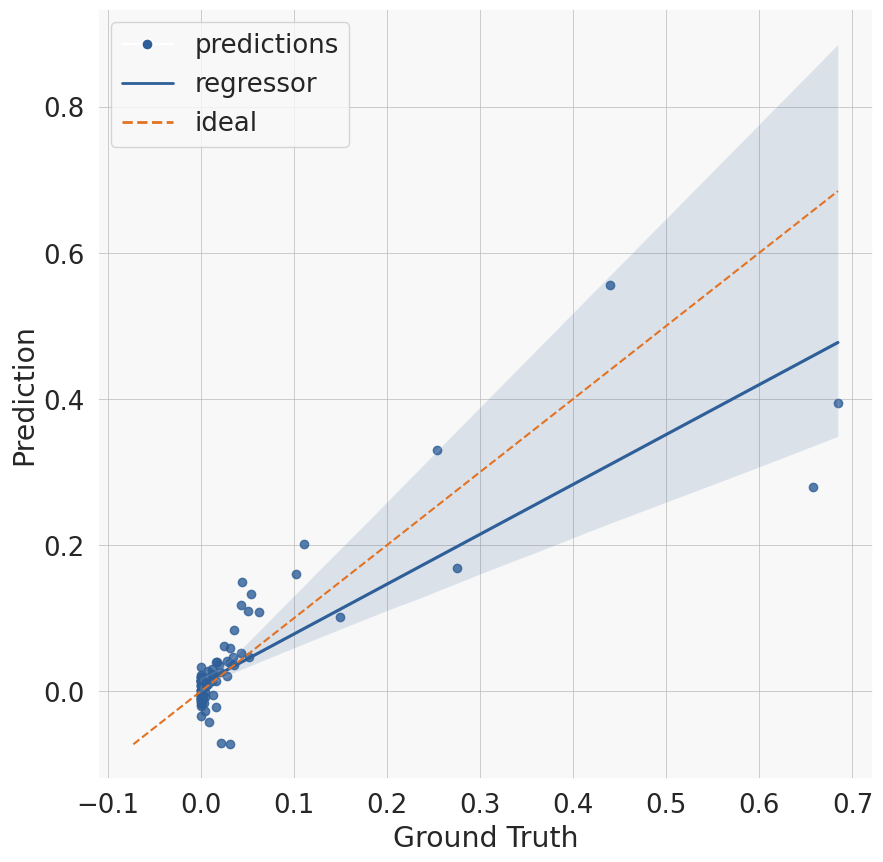

In [11]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [12]:
sample = pd.DataFrame([{
    "batch_size": 128,
    "image_size": 512,
    "kernel_size": 7,
    "in_channels": 64,
    "out_channels": 64,
    "stride": 2,
    "padding": 3
}])

# Lấy lại transformer đã fit từ bước train
poly = transformers_dict["x_preprocessors"][0]  # Đã fit rồi
x_sample = poly.transform(sample[param_cols])

# Lấy scaler đầu ra
y_scaler = transformers_dict["y_preprocessor"]

# Dự đoán
y_pred_scaled = model.predict(x_sample)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

print(f"🔋 Estimated energy consumption: {y_pred.item():.6f}")



🔋 Estimated energy consumption: 0.001977


In [13]:
# save model & estimates
models['param'] = model
estimates['param'] = y_hat

### Notes
- there are only slight differences between using Lasso or LinearRegression
- Lasso seems slightly more robust as it has lower deviations in cross validation scores

## Feature-Set: Module Parameters + Log-Parameters


In [14]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
print(f"Used features: {param_cols_with_log}")
dfs = split_data_set(data_linear_with_log, param_cols_with_log, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=3, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, transformers = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(Lasso(max_iter=int(1e5)), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'image_size', 'kernel_size', 'in_channels', 'out_channels', 'stride', 'padding', 'log_batch_size', 'log_image_size', 'log_kernel_size', 'log_in_channels', 'log_out_channels', 'log_stride', 'log_padding']


/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Average R2 Cross-Validation Score: 0.622 (± 0.192)
Average MSE Cross-Validation: -2.105e-03 (± 1.734e-03)
Validation R2 Score: 0.643
Validation MSE: 3.272e-03


In [15]:
dfs['x_train'].shape

(683, 470)

Test R2 Score: 0.7954
Test MSE: 2.460e-03


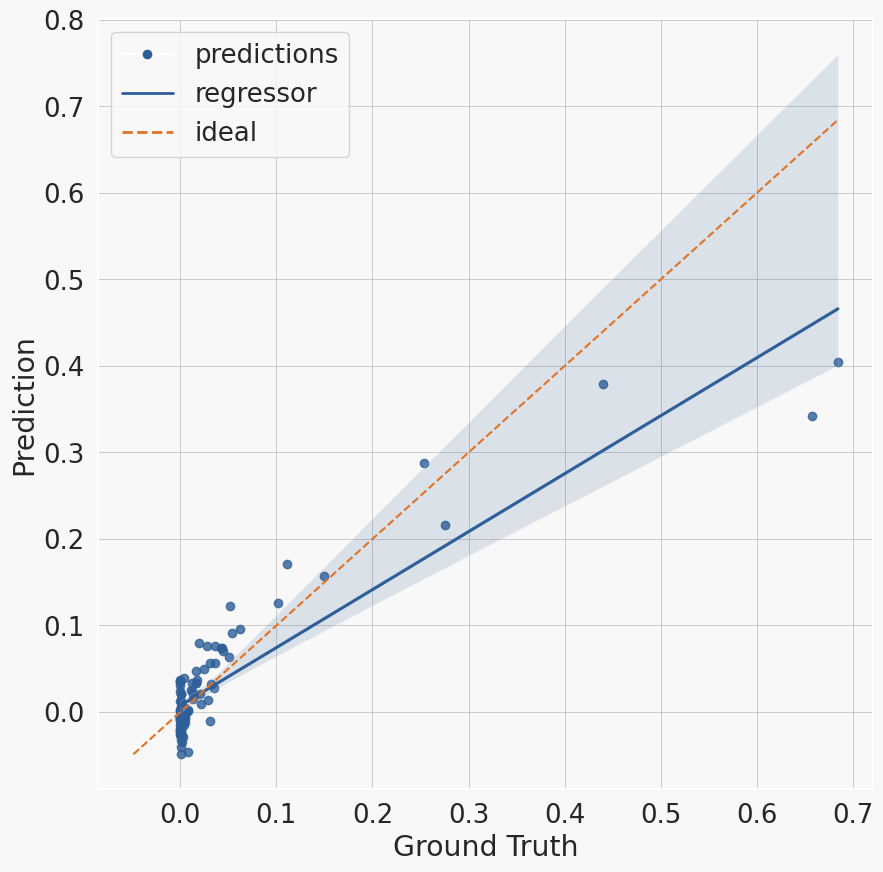

In [16]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [17]:
import pickle

with open("linear_test_conv_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl")
with open("x_transformer.pkl", "wb") as f:
    pickle.dump(transformers["x_preprocessors"][0], f)

with open("y_transformer.pkl", "wb") as f:
    pickle.dump(transformers["y_preprocessor"], f)

print("✅ Transformers đã được lưu thành công.")

✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl
✅ Transformers đã được lưu thành công.


In [18]:
# save model & estimates
models['param_log_param'] = model
estimates['param_log_param'] = y_hat

### Notes
- LinearRegression works better without polynomial features than a Lasso regressor, but completely fails with polynomial features
- Generally more stable with log-features

## Feature-Set: MACs Only

In [22]:
dfs = split_data_set(data, ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": None,
    "y_preprocessor": MinMaxScaler()
}
dfs, transformers = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Average R2 Cross-Validation Score: 0.994 (± 0.005)
Average MSE Cross-Validation: -2.291e-05 (± 1.329e-05)
Validation R2 Score: 0.998
Validation MSE: 1.745e-05


Test R2 Score: 0.9977
Test MSE: 2.779e-05


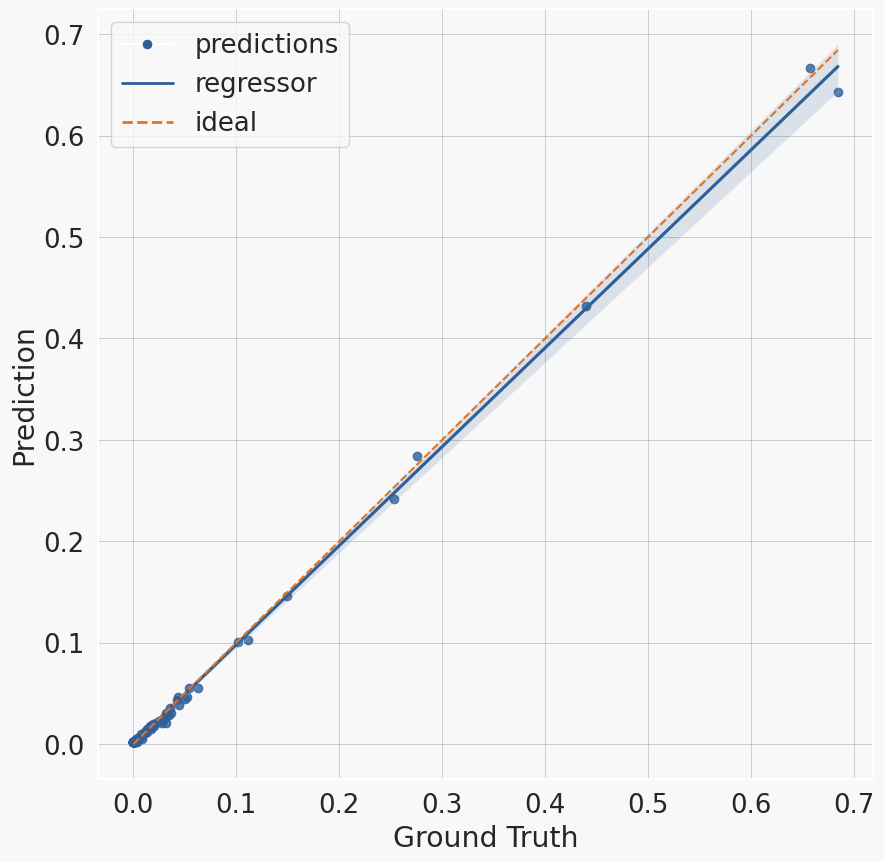

In [23]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [24]:
import pickle

with open("./mac_only/conv2d/linear_test_conv_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl")
# with open("x_transformer.pkl", "wb") as f:
#     pickle.dump(transformers["x_preprocessors"][0], f)

with open("./mac_only/conv2d/y_transformer.pkl", "wb") as f:
    pickle.dump(transformers["y_preprocessor"], f)

print("✅ Transformers đã được lưu thành công.")

✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl
✅ Transformers đã được lưu thành công.


In [55]:
# save model & estimates
models['macs'] = model
estimates['macs'] = y_hat

### Notes
- easily outperforms all previousm feature sets
- extremely low deviations in R2 scores in the 5 folds
- very low test MSE

# Feature-Set: Module Parameters + MACs

In [101]:
dfs = split_data_set(data, param_cols + ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, train = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Average R2 Cross-Validation Score: 0.996 (± 0.004)
Average MSE Cross-Validation: -1.644e-05 (± 9.509e-06)
Validation R2 Score: 0.999
Validation MSE: 1.152e-05


/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [57]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

Test R2 Score: 0.9979
Test MSE: 2.501e-05


In [58]:
# save model & estimates
models['param_macs'] = model
estimates['param_macs'] = y_hat

### Notes
- fitting error slightly smaller on the folds, but minimally better performance on validation set compared to MACs only
- test score is lower and MSE significantly larger

## Feature-Set: Module Parameters + Log-Parameters + MACs

In [7]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
dfs = split_data_set(data_linear_with_log, param_cols_with_log + ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, transformers = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Average R2 Cross-Validation Score: 0.996 (± 0.004)
Average MSE Cross-Validation: -1.560e-05 (± 9.004e-06)
Validation R2 Score: 0.999
Validation MSE: 1.124e-05


In [8]:
data_linear_with_log[param_cols_with_log+ ['macs']]

batch_size  image_size  kernel_size  in_channels  out_channels  stride  \
0           123         127            7           80            29       1   
1            73         158            4          344           412       2   
2           107         211            1           54           167       3   
3           241          66            8           43           270       1   
4           224          62            7          116           216       1   
..          ...         ...          ...          ...           ...     ...   
971         123         222           11           55           256       4   
972         234          16            6          445            64       4   
973         214         186            2          289           373       4   
974         172          68           11          104            89       1   
975          72         221           11          271           351       4   

     padding  log_batch_size  log_image_size  log_kernel_size  \
0          2        4.820282        4.852030         2.079442   
1          3        4.304065        5.068904         1.609438   
2          3        4.682131        5.356586         0.693147   
3          2        5.488938        4.204693         2.197225   
4          1        5.416100        4.143135         2.079442   
..       ...             ...             ...              ...   
971        3        4.820282        5.407172         2.484907   
972        1        5.459586        2.833213         1.945910   
973        1        5.370638        5.231109         1.098612   
974        0        5.153292        4.234107         2.484907   
975        0        4.290459        5.402677         2.484907   

     log_in_channels  log_out_channels  log_stride  log_padding          macs  
0           4.394449          3.401197    0.693147     1.098612  2.185345e+11  
1           5.843544          6.023448    1.098612     1.386294  1.086294e+12  
2           4.007333          5.123964    1.386294     1.386294  5.237315e+09  
3           3.784190          5.602119    0.693147     1.098612  7.109976e+11  
4           4.762174          5.379897    0.693147     0.693147  9.253121e+11  
..               ...               ...         ...          ...           ...  
971         4.025352          5.549076    1.609438     1.386294  6.339920e+11  
972         6.100319          4.174387    1.609438     0.693147  3.838888e+09  
973         5.669881          5.924256    1.609438     0.693147  2.040101e+11  
974         4.653960          4.499810    0.693147     0.000000  6.480786e+11  
975         5.605802          5.863631    1.609438     0.000000  2.327873e+12  

[976 rows x 15 columns]

Test R2 Score: 0.9979
Test MSE: 2.578e-05


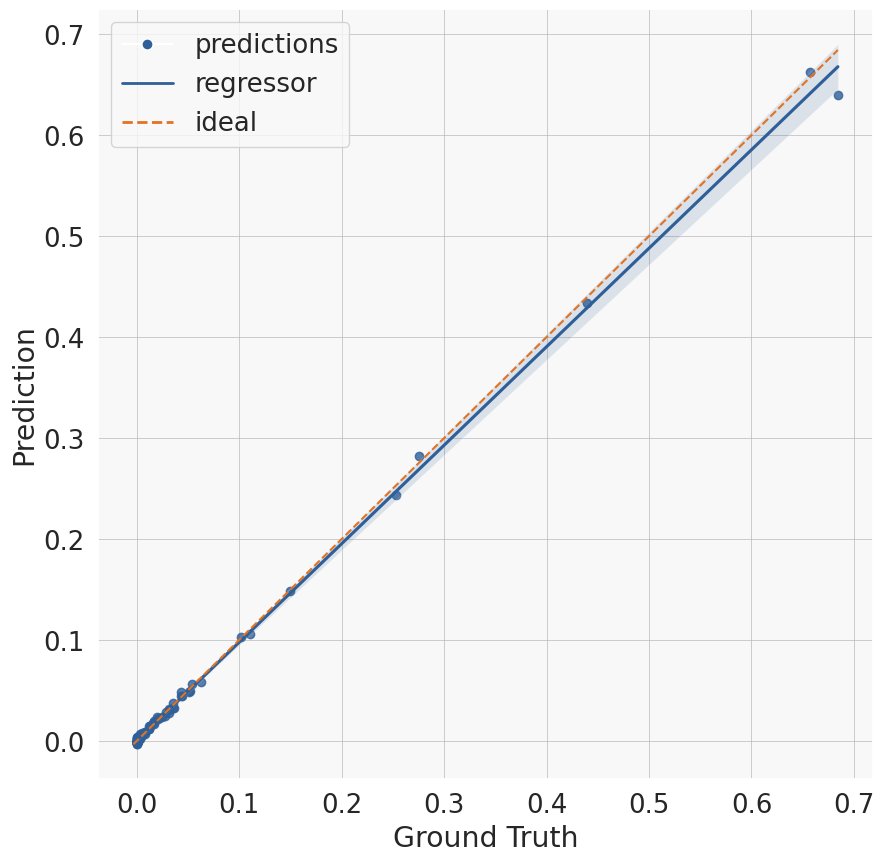

In [9]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [114]:
# save model & estimates
models['param_log_param_macs'] = model
estimates['param_log_param_macs'] = y_hat

In [10]:
import pickle

with open("./conv2d/linear_test_conv_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl")
with open("./conv2d/x_transformer.pkl", "wb") as f:
    pickle.dump(transformers["x_preprocessors"][0], f)

with open("./conv2d/y_transformer.pkl", "wb") as f:
    pickle.dump(transformers["y_preprocessor"], f)

print("✅ Transformers đã được lưu thành công.")

✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl
✅ Transformers đã được lưu thành công.


### Notes
- similar performance to previous model
- no noticeable improvement comes from adding log parameters
- MACs only model much simpler and also performs better
- one could potentially also add polynomial terms here, but given the good score the increase in model complexity is hardly worth it. Also we did not notice and real performance improvement on the test set

# Comparison of all models

In [62]:
df_to_plot = pd.DataFrame(columns=["features","y_hat",'y'])
for model_name, model in models.items():
    new_df = pd.DataFrame(data={'features':[model_name]*len(dfs['y_test']),'y_hat':np.squeeze(estimates[model_name]),'y':np.squeeze(dfs['y_test'])})
    df_to_plot = pd.concat([df_to_plot, new_df], ignore_index=True)
    print(f"{'{:<35}'.format(model_name)} {round(r2_score(dfs['y_test'], estimates[model_name]), 3)}")
min_x = min(min(df_to_plot.y_hat),min(df_to_plot.y))
max_x = max(max(df_to_plot.y_hat),max(df_to_plot.y))
sns.set(font_scale=1)
plt.figure(figsize=(8,6))
g = sns.lmplot(data=df_to_plot, x="y", y="y_hat", hue="features", ci=95, height=6, aspect=1.5, facet_kws={'legend_out':False}, markers='o')
plt.plot([min_x, max_x], [min_x, max_x],ls='--', marker='', label='optimum', color="#f032e6")
line = Line2D([0], [0], ls='--', label='optimum', color='#f032e6')
g.set(xlabel='Ground Truth', ylabel='Prediction')
sns.move_legend(g, "upper left", bbox_to_anchor=(.1, .97))
legend1 = g.legend
legend2 = plt.legend(handles = [plt.plot([],ls="--", color=line.get_color())[0]], labels=[line.get_label()], loc='upper right')
g.fig.add_artist(legend2)
g.fig.add_artist(legend1)

param                               0.71
param_log_param                     0.795
macs                                0.998
param_macs                          0.998
param_log_param_macs                0.998


/tmp/ipykernel_2985461/2995408807.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_to_plot = pd.concat([df_to_plot, new_df], ignore_index=True)


TypeError: 'module' object is not callable